In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [19]:
dataframe = pd.read_csv("Google Finance.csv")
dataframe.head()

,Date,Close
0,02/01/2023 16:56:00,"14,3"
1,03/01/2023 16:56:00,"14,57"
2,04/01/2023 16:56:00,"14,97"
3,05/01/2023 16:56:00,"14,8"
4,06/01/2023 16:56:00,"14,55"


# Tratamento de Dados

## String para Decimal

Os valores numéricos estão representados como strings. É preciso convertê-los.

In [20]:
dataframe['Close'] = dataframe['Close'].str.replace(',', '.')
dataframe['Close'] = pd.to_numeric(dataframe['Close'])

## Visualizar dados

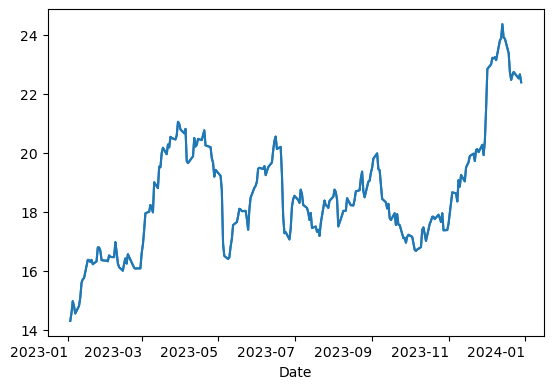

In [21]:
date_time = pd.to_datetime(dataframe['Date'], format='%d/%m/%Y %H:%M:%S')

plot_features = dataframe['Close']
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = dataframe['Close'][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

## Filtros

Os filtros a seguir não se aplicam ao projeto atual devido ao dataset utilizado, porém podem ser interessantes posteriormente.

In [6]:
# Filtrar colunas com mais de 90% de elementos nulos

# dataframe = dataframe[dataframe.columns[dataframe.isnull().mean() < 0.90]]

In [7]:
# Tratando NaN's

# dataframe = dataframe.interpolate()
# dataframe = dataframe.fillna(method='bfill')

# Tratamento para a Rede Neural

## Criando entradas e saídas de treino

As entradas (X_train) são os 60 valores anteriores do preço da ação. A saída é o valor seguinte.

A seguir, também serão divididos os datasets de treino e de avaliação. Aprox. 70% dos dados serão
usados no treino, e o restante na avaliação.

É importante notar também que a divisão foi feita seguindo a ordem dos dados no arquivo (os 70%
primeiros são para treino, os 30% últimos para avaliação). Pode ser interessante mudar isso.

In [23]:
dataset = dataframe.iloc[:, 1].values

# Separação entre treino e avaliação

training_df = dataframe.iloc[0:int(dataset.shape[0] * 0.7), :]
test_df = dataframe.iloc[int(dataset.shape[0] * 0.7):, :]

training_set = training_df.iloc[:, 1].values
test_set = test_df.iloc[:, 1].values

# Separação entre entradas e saídas de treino

X_train = []
y_train = []

for i in range(60, len(training_set)):
    X_train.append(training_set[i-60:i])
    y_train.append(training_set[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_train.shape == ((int(dataset.shape[0] * 0.7) - 60), 60, 1)

# Rede Neural

Foi implementada uma RNN, adequada para predição de séries temporais.

In [24]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

A próxima célula captura o output (longo) para a variável history

In [25]:
%%capture history
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Avaliando modelo

In [26]:
# Separação entre entradas e saídas de avaliação

X_test = []
y_test = []

for i in range(60, len(test_set)):
    X_test.append(test_set[i-60:i])
    y_test.append(test_set[i])

X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# X_train.shape == (((dataset.shape[0] - int(dataset.shape[0] * 0.7)) - 60), 60, 1)

In [27]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 2s 2s/step - loss: 22.7052


22.70517349243164

TODOs:
- Considerar que existem dias faltantes na entrada
- Revisar divisão de dados entre treino e avaliação
- Melhorar modelo
- Revisar epochs e batch size